In [4]:
##||-- Env Setup: Draknet and GPU training specification --||##
#--|| Enable GPU ||--#
!nvidia-smi

#--|| Install Darknet ||--#
!git clone https://github.com/pjreddie/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make -j8

/bin/bash: line 1: nvidia-smi: command not found
Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955 (from 1)
Receiving objects: 100% (5955/5955), 6.37 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.
/content/darknet/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -f

In [5]:
#||-- OCR Data Import --||#
from google.colab import files;
uploaded = files.upload();

Saving DDDM-OCR.zip to DDDM-OCR.zip


In [6]:
import zipfile
import os

zip_filename = next(iter(uploaded))
!mkdir dataset

#||-- Extract the zip file --||#
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('dataset')

#||-- Import Checking --||#
print("Extracted files:")
!ls -l dataset/DDDM-OCR/

Extracted files:
total 58012
-rw-r--r-- 1 root root 2331296 May  4 17:49  20200614_130201a.jpg
-rw-r--r-- 1 root root  169377 May  4 17:49  20200614_130201b.jpg
-rw-r--r-- 1 root root     305 May  4 17:49  20200614_130201b.txt
-rw-r--r-- 1 root root    2230 May  4 17:49  20200614_130201b.xml
-rw-r--r-- 1 root root 2362752 May  4 17:49  20200614_130203a.jpg
-rw-r--r-- 1 root root  220492 May  4 17:49  20200614_130203b.jpg
-rw-r--r-- 1 root root     305 May  4 17:49  20200614_130203b.txt
-rw-r--r-- 1 root root    2233 May  4 17:49  20200614_130203b.xml
-rw-r--r-- 1 root root 2423054 May  4 17:49  20200614_130217a.jpg
-rw-r--r-- 1 root root   18884 May  4 17:49  20200614_130217b.jpg
-rw-r--r-- 1 root root      37 May  4 17:49  20200614_130217b.txt
-rw-r--r-- 1 root root     530 May  4 17:49  20200614_130217b.xml
-rw-r--r-- 1 root root 3610593 May  4 17:49 '20200614_130229(0)a.jpg'
-rw-r--r-- 1 root root   39446 May  4 17:49 '20200614_130229(0)b.jpg'
-rw-r--r-- 1 root root     151 May  4 1

In [7]:
#||-- 1- Pre Image Preprocessing: CSV Annotations checking and Image Acccess Verification --||#
import pandas as pd
import glob

csv_files = glob.glob('dataset/DDDM-OCR/*.csv')
annotations_path = csv_files[0]

#--| Read the CSV with semicolon |--#
df = pd.read_csv(annotations_path, delimiter=';')
print(df.head())

#--| Image Access Verification |--#
sample_image = df['Image name'].iloc[0]
if os.path.exists(f'dataset/DDDM-OCR/{sample_image}'):
    print("\nFile structure Verified!")
else:
    print("\nWarning: Images not found in expected location")

  Class  x min  y min  x max - x min  y max - ymin            Image name  \
0     5     14    256            139           183  20200614_130201b.jpg   
1     9    146    247            130           197  20200614_130201b.jpg   
2     9    273    240            137           194  20200614_130201b.jpg   
3     6    412    226            127           201  20200614_130201b.jpg   
4     2    539    208            139           227  20200614_130201b.jpg   

   Width  Height  
0   1569     499  
1   1569     499  
2   1569     499  
3   1569     499  
4   1569     499  

File structure Verified!


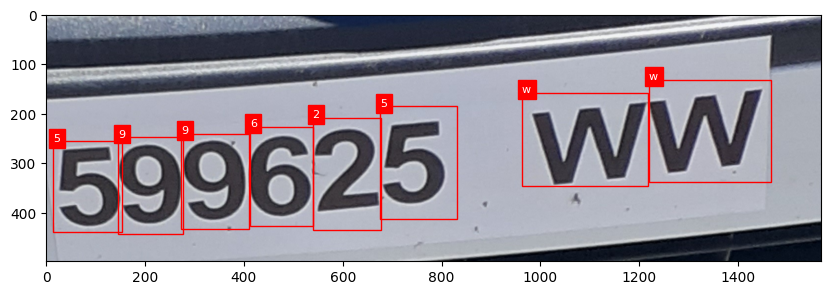

In [8]:
#||-- 2- Sample visualization (with annotation) --||#

from PIL import Image
import matplotlib.pyplot as plt

def show_image_with_boxes(img_name, df):
    img_path = f'dataset/DDDM-OCR/{img_name}'
    #||-- Path checking ||--##
    if not os.path.exists(img_path):
        print(f"Image {img_path} not found!")
        return

    img = Image.open(img_path)
    annotations = df[df['Image name'] == img_name]

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    ax = plt.gca()

    #||-- Fetch annotations --||
    for _, row in annotations.iterrows():
        rect = plt.Rectangle(
            (row['x min'], row['y min']),
            row['x max - x min'],
            row['y max - ymin'],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(
            row['x min'],
            row['y min'],
            row['Class'],
            color='white',
            backgroundcolor='red',
            fontsize=8
        )

    plt.show()

show_image_with_boxes(df['Image name'].iloc[0], df)

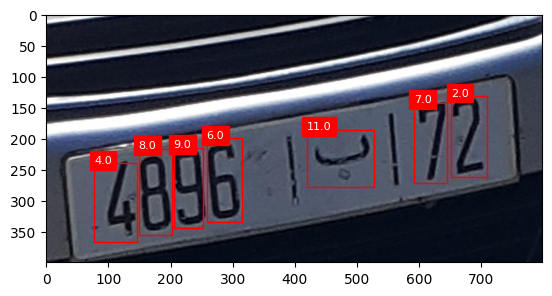

In [12]:
#||-- 3- First Preprocessing step: YOLO Annotations Checking --||#
def plot_yolo_annotations(img_name, class_names):
    """Visualize YOLO annotations on image"""
    img = Image.open(f"dataset/DDDM-OCR/{img_name}")
    width, height = img.size

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    txt_path = f"{os.path.splitext(img_name)[0]}.txt"
    # Read YOLO annotation file
    with open(f"dataset/DDDM-OCR/{txt_path}") as f:
        lines = f.readlines()

    # Draw each bounding box
    for line in lines:
        class_id, x_center, y_center, w, h = map(float, line.split())

        # Convert YOLO format to pixel coordinates
        x_center *= width
        y_center *= height
        w *= width
        h *= height
        x_min = x_center - w/2
        y_min = y_center - h/2

        # Create rectangle patch
        rect = plt.Rectangle(
            (x_min, y_min), w, h,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

        label = class_mapping.get(int(class_id), str(class_id))
        plt.text(
            x_min, y_min,
            label,
            color='white',
            backgroundcolor='red',
            fontsize=8
        )

    plt.show()


##||--> Classes Mapping: Letters, and Numbers <--||##
class_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'a': 10,
    'b': 11,
    'ch': 12,
    'd': 13,
    'h': 14,
    'w': 15,
    'waw': 16
}

yolo_annotations = plot_yolo_annotations(df['Image name'].iloc[25], class_mapping)

In [11]:
import random
import shutil

#||-- 4- Data preparation: Train / Test splitting --||#

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

!mkdir -p darknet/data/obj
!mkdir -p darknet/backup

src_dir = "dataset/DDDM-OCR"
for f in os.listdir(src_dir):
    if f.endswith(('.jpg', '.png', '.txt')):
        shutil.copy(os.path.join(src_dir, f), 'darknet/data/obj/')

image_files = [f for f in os.listdir('darknet/data/obj') if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)

total = len(image_files)
train_end = int(TRAIN_RATIO * total)
val_end = train_end + int(VAL_RATIO * total)

with open('darknet/data/train.txt', 'w') as f:
    for img in image_files[:train_end]:
        f.write(f'data/obj/{img}\n')

with open('darknet/data/valid.txt', 'w') as f:
    for img in image_files[train_end:val_end]:
        f.write(f'data/obj/{img}\n')

with open('darknet/data/test.txt', 'w') as f:
    for img in image_files[val_end:]:
        f.write(f'data/obj/{img}\n')

print(f"""\
Dataset split complete:
- Training:   {train_end} images
- Validation: {val_end - train_end} images
- Test:       {total - val_end} images\
""")

Dataset split complete:
- Training:   509 images
- Validation: 145 images
- Test:       74 images


In [17]:
#||-- 5- Tiny Yolo v3 configuration and architecture --||#
!echo "classes = 16" > obj.data
!echo "train = data/train.txt" >> obj.data
!echo "valid = data/valid.txt" >> obj.data
!echo "names = data/obj.names" >> obj.data
!echo "backup = backup/" >> obj.data
!cat obj.data

!echo "_______________________________________________"

!echo "0" > obj.names
!echo "1" >> obj.names
!echo "2" >> obj.names
!echo "3" >> obj.names
!echo "4" >> obj.names
!echo "5" >> obj.names
!echo "6" >> obj.names
!echo "7" >> obj.names
!echo "8" >> obj.names
!echo "9" >> obj.names
!echo "a" >> obj.names
!echo "b" >> obj.names
!echo "ch" >> obj.names
!echo "d" >> obj.names
!echo "h" >> obj.names
!echo "w" >> obj.names
!echo "waw" >> obj.names
!cat obj.names

!echo "_______________________________________________"

classes = 16
train = data/train.txt
valid = data/valid.txt
names = data/obj.names
backup = backup/
_______________________________________________
0
1
2
3
4
5
6
7
8
9
a
b
ch
d
h
w
waw
_______________________________________________
--2025-05-04 18:51:43--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2-tiny.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1488 (1.5K) [text/plain]
Saving to: ‘yolov2-tiny-ARCHITECTURE.cfg’

yolov2-tiny-ARCHITE 100%[===================>]   1.45K  --.-KB/s    in 0s      

2025-05-04 18:51:43 (17.3 MB/s) - ‘yolov2-tiny-ARCHITECTURE.cfg’ saved [1488/1488]

--2025-05-04 18:51:43--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
Resolving raw.githubusercontent.com (raw.githubus

In [19]:
yolov2_tiny = files.upload();

Saving yolov2-tiny.cfg to yolov2-tiny (1).cfg


In [20]:
yolov3_tiny = files.upload();

Saving yolov3-tiny.cfg to yolov3-tiny.cfg


In [21]:
!echo "TinyYoloV2 Architecture:"
!echo "________________________"
!cat yolov2_tiny
!echo "________________________"
!echo "TinyYoloV3 Architecture:"
!echo "________________________"
!cat yolov3-tiny.cfg

TinyYoloV2 Architecture:
________________________
cat: yolov2_tiny: No such file or directory
________________________
TinyYoloV3 Architecture:
________________________
[net]
# Testing
batch=1
subdivisions=1
# Training
# batch=64
# subdivisions=2
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
s

In [23]:
!head -n 5 darknet/data/train.txt

data/obj/20200614_205457a.jpg
data/obj/20201106_224055.jpg
data/obj/20201106_223032.jpg
data/obj/20200626_122121a.jpg
data/obj/20200614_161723.jpg


In [ ]:
!git clone https://github.com/AlexeyAB/darknet DARKNET
%cd DARKNET
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!make
!./darknet detector calc_anchors data/obj.data -num_of_clusters 5 -width 416 -height 416

Cloning into 'DARKNET'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 15900 (delta 23), reused 11 (delta 11), pack-reused 15860 (from 3)
Receiving objects: 100% (15900/15900), 14.51 MiB | 14.59 MiB/s, done.
Resolving deltas: 100% (10694/10694), done.
/content/darknet/darknet/darknet/DARKNET/DARKNET
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_op